# Parcel Training V1


### Clone repository

In [ ]:
!git clone "https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes.git"

Cloning into 'wastedata-Mask_RCNN-multiple-classes'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (151/151), 12.19 MiB | 1.62 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!unzip "/content/train2.zip" -d "/content/dataset/train/"
#!rm -rf "/content/dataset/train/"

Archive:  /content/train2.zip
  inflating: /content/dataset/train/965729e9e2411197bad1ef7c07f23899.jpg  
  inflating: /content/dataset/train/Big-Paper-Envelope-Mockup-1000x750.jpg  
  inflating: /content/dataset/train/cat_scatole_certificate_per_quantit__limitate_1.jpg  
  inflating: /content/dataset/train/cat_scatole_omologate_certificate_1.jpg  
  inflating: /content/dataset/train/code_838_-_photo_1_1.jpg  
  inflating: /content/dataset/train/courier-services-500x500.jpg  
  inflating: /content/dataset/train/depositphotos_169105282-stock-photo-envelopes-of-uinited-parcel-service.jpg  
  inflating: /content/dataset/train/depositphotos_169105346-stock-photo-envelopes-of-uinited-parcel-service.jpg  
  inflating: /content/dataset/train/depositphotos_257270340-stock-photo-parcel-in-female-hands-top.jpg  
  inflating: /content/dataset/train/exempt-patient-specimen-package.png  
  inflating: /content/dataset/train/fibreboard-boxes-500x500.jpg  
  inflating: /content/dataset/train/free-kraft

In [ ]:
import shutil, os
def copytree(src = '/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN', dst = '/content/', symlinks=False, ignore=None):
    try:
      shutil.rmtree('/content/.ipynb_checkpoints')
    except:
      pass
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
copytree()

shutil.copytree('/content/MaskRCNN/newdataset','/content/dataset')

FileNotFoundError: ignored

In [ ]:
!pip install keras==2.2.5
!pip install -U scikit-image==0.16.2
!pip install h5py==2.10.0
%tensorflow_version 1.x

TensorFlow 1.x selected.


### Startup configuration
Import required libraries and initialize paths

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


### Class definitions
Define the classes used to determine and train the model

In [ ]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + toy

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.98

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "parcel")

        # self.add_class("object", 3, "xyz")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project_sides.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

         # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        
        print(annotations)
        # Add images
        for a in annotations:

            print(a)
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"parcel": 1} #,"xyz": 3}
            print(name_dict)
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/dataset", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

### Configuration
Setup the config and the modul used for testing

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

### Training
Get COCO weights for training

In [ ]:
model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
train(model)

[{'filename': '_106186600_medium.jpg', 'size': 72640, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [99, 103, 581, 582], 'all_points_y': [113, 425, 429, 114]}, 'region_attributes': {'name': 'parcel'}}], 'file_attributes': {}}, {'filename': '2Ufb4sikyt1cg6ONNnvdRRNE3_smaller.jpg', 'size': 17435, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [167, 192, 354, 324], 'all_points_y': [73, 180, 142, 37]}, 'region_attributes': {'name': 'parcel'}}], 'file_attributes': {}}, {'filename': '5fe9c72a06bec675d75dd9d0_s4.png', 'size': 69732, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [118, 394, 518, 274], 'all_points_y': [125, 185, 95, 54]}, 'region_attributes': {'name': 'parcel'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [120, 386, 394, 116], 'all_points_y': [319, 401, 183, 125]}, 'region_attributes': {'name': 'parcel'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [512, 516, 394, 387], 'all_points_y'

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
100/100 [==============================] - 333s 3s/step - loss: 1.6261 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 0.4583 - mrcnn_class_loss: 0.1813 - mrcnn_bbox_loss: 0.5578 - mrcnn_mask_loss: 0.3649 - val_loss: 2.0084 - val_rpn_class_loss: 0.0290 - val_rpn_bbox_loss: 0.8544 - val_mrcnn_class_loss: 0.2917 - val_mrcnn_bbox_loss: 0.4907 - val_mrcnn_mask_loss: 0.3426

Epoch 2/10
100/100 [==============================] - 274s 3s/step - loss: 0.9243 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.2650 - val_loss: 1.7619 - val_rpn_class_loss: 0.0227 - val_rpn_bbox_loss: 0.6874 - val_mrcnn_class_loss: 0.3111 - val_mrcnn_bbox_loss: 0.4449 - val_mrcnn_mask_loss: 0.2958
Epoch 3/10
100/100 [==============================] - 274s 3s/step - loss: 0.6830 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1999 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.2085 - val_loss: 1.6304 - val_rpn_clas

In [ ]:
while True:pass

KeyboardInterrupt: ignored

# Detection

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

# Root directory of the project
#ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
WEIGHTS_PATH = "/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/logs/object20220330T0941/mask_rcnn_object_0010.h5" 

In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/content/dataset/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# Load validation dataset
CUSTOM_DIR = "/content/dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

[{'filename': 'parcel-png-11553937494n0vwuswdd7.png', 'size': 422245, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [226, 224, 562, 568], 'all_points_y': [119, 385, 385, 131]}, 'region_attributes': {'name': 'parcel'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [324, 584, 584, 320], 'all_points_y': [538, 540, 382, 382]}, 'region_attributes': {'name': 'parcel'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [128, 131, 310, 312], 'all_points_y': [574, 745, 714, 554]}, 'region_attributes': {'name': 'parcel'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [25, 128, 131, 28], 'all_points_y': [536, 576, 745, 683]}, 'region_attributes': {'name': 'parcel'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [192, 22, 129, 309], 'all_points_y': [519, 535, 573, 554]}, 'region_attributes': {'name': 'parcel'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [545, 542, 811, 818], 'all_points_y': [559, 717, 723, 562]}, 're

In [ ]:
#LOAD MODEL
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [ ]:
# Load COCO weights, Or load the last model you trained
weights_path = WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/logs/object20220330T0941/mask_rcnn_object_0010.h5
Re-starting from epoch 10


0
image ID: object.parcel-png-11553937494n0vwuswdd7.png (0) /content/dataset/val/parcel-png-11553937494n0vwuswdd7.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (8, 4)                min:  114.00000  max:  910.00000  int32
gt_mask                  shape: (1024, 1024, 8)       min:    0.00000  max:    1.00000  uint8
1
Processing 1 images
image                    shape: (450, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.100

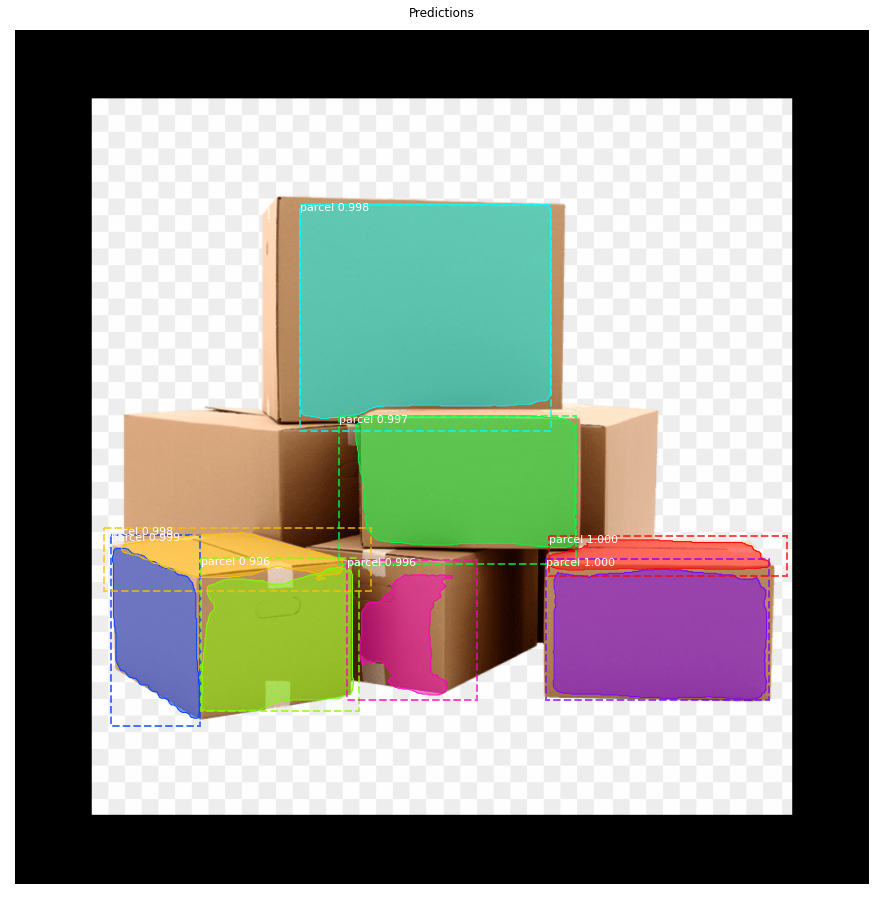

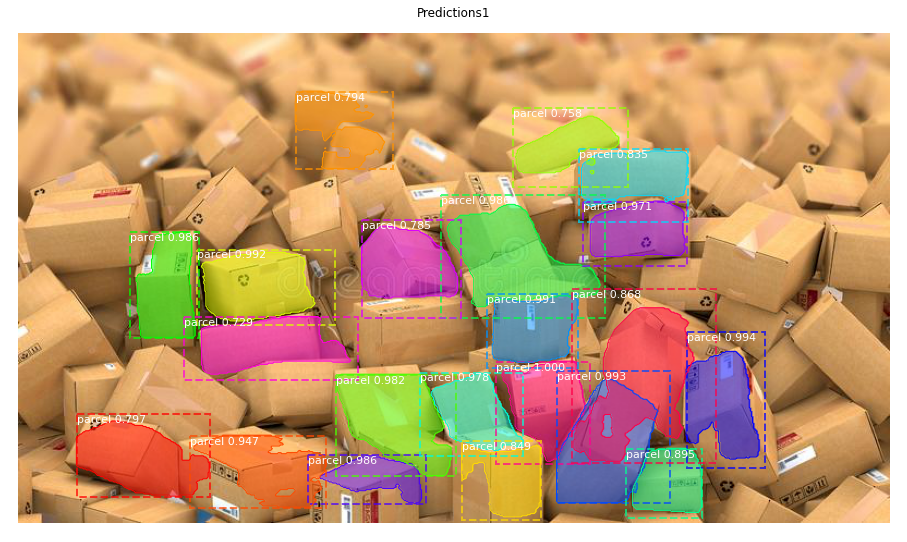

In [ ]:
#RUN DETECTION
image_id = random.choice(dataset.image_ids)
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


# This is for predicting images which are not present in dataset
#image_id = random.choice(dataset.image_ids)
image1 = mpimg.imread('/content/dataset/test/test3.jpg')

    # Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)


    # Display results
ax = get_ax(1)
r1 = results1[0]

np.set_printoptions(threshold=sys.maxsize)
print(r1['masks'][400][400])

visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset.class_names, r1['scores'], ax=ax,
                            title="Predictions1")